# Model with final variables (delay_flag)

In [1]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso, LogisticRegression 
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Import flight data, then filter airline and delay_flag

In [2]:
flight_data = pd.read_csv("../../data/clean_data/flight_delay_clean.csv")
flight_data.shape

(303748, 24)

In [3]:
# filter for only delay and no delay data
flight_delay_data = flight_data[flight_data['delay_flag'] != "Cancelled"].copy()
flight_delay_data.shape

(295938, 24)

In [4]:
# filter for required airlines
airline_delay_data = flight_delay_data[flight_delay_data['origin'] == "EWR"].copy()
airline_delay_data.reset_index(inplace=True, drop=True)
airline_delay_data.shape

(113067, 24)

In [5]:
airline_delay_data.describe()

,month,wday,hour,flights_per_day,flights_per_hour,dep_delay,distance,nose_dir,seats,wind_dir,wind_speed,visib,prcp,snow,snwd,tavg,pres
count,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,106154.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000,113067.000000
mean,6.580939,3.926106,13.167158,841.001106,52.112694,18.781599,1143.929953,232.498141,152.126910,181.783014,8.476106,9.375244,0.119386,0.047532,0.167378,57.018883,1017.158928
std,3.411402,1.947350,4.768755,81.433341,12.495151,47.995638,767.393662,61.939140,76.943562,113.615762,4.452869,1.820046,0.371864,0.408576,0.761990,16.816694,6.860998
min,1.000000,1.000000,1.000000,535.000000,2.000000,0.000000,93.000000,7.496324,1.000000,0.000000,0.000000,0.130000,0.000000,0.000000,0.000000,16.000000,995.800000
25%,4.000000,2.000000,9.000000,820.000000,45.000000,0.000000,628.000000,207.829268,100.000000,70.000000,5.753900,10.000000,0.000000,0.000000,0.000000,43.000000,1013.200000
50%,7.000000,4.000000,13.000000,863.000000,54.000000,0.000000,937.000000,244.843285,149.000000,210.000000,8.055460,10.000000,0.000000,0.000000,0.000000,58.000000,1016.300000
75%,10.000000,6.000000,17.000000,899.000000,60.000000,14.000000,1569.000000,278.009949,191.000000,270.000000,11.507800,10.000000,0.040000,0.000000,0.000000,72.000000,1021.300000
max,12.000000,7.000000,23.000000,931.000000,84.000000,1217.000000,4962.000000,329.743683,552.000000,360.000000,26.467940,10.000000,3.860000,7.800000,5.900000,87.000000,1039.100000


In [6]:
# convert outcome flag to numeric data from category
airline_delay_data['delayed_flag'] = (np.where(airline_delay_data['delay_flag'] == "Yes", 1, 0))
list(airline_delay_data)

['sch_departure',
 'month',
 'wday',
 'hour',
 'cycle',
 'flights_per_day',
 'flights_per_hour',
 'origin',
 'dep_delay',
 'delay_flag',
 'dest',
 'distance',
 'nose_dir',
 'carrier',
 'type',
 'seats',
 'wind_dir',
 'wind_speed',
 'visib',
 'prcp',
 'snow',
 'snwd',
 'tavg',
 'pres',
 'delayed_flag']

# Select required variables

In [7]:
delay_df = airline_delay_data[['delayed_flag', 'hour', 'prcp', 'flights_per_day', 'pres',
                               'tavg', 'month', 'flights_per_hour', 'visib']].dropna().copy()
delay_df.shape

(113067, 9)

In [8]:
# create dummies if required
delay_df = pd.get_dummies(delay_df, drop_first = True)
delay_df.shape

(113067, 9)

In [9]:
# file paths to save outputs
profile_report_save = "profile_reports/model_with_final_vars_profile_report.html"
plot_tree_filename = "saved_models/model_with_final_vars_decision_tree.png"

In [10]:
profile = ProfileReport(delay_df, title="Profiling Report")
profile.to_file(profile_report_save)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\mfarmahan\anaconda3\lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Separate response and scale features

In [11]:
delay_predictors = delay_df.drop(columns = 'delayed_flag')
delay_response = delay_df['delayed_flag']

In [12]:
# scale features
ss = StandardScaler()
delay_predictors_scaled = ss.fit_transform(delay_predictors)
delay_predictors = pd.DataFrame(delay_predictors_scaled, columns = delay_predictors.columns)

In [13]:
# delay_predictors.mean()

In [14]:
# delay_predictors.std()

# Model selection

## Balance dataset (undersample)

In [15]:
# check number of outcomes: OnTime vs Delayed
bal_delay_predictors, bal_delay_response = delay_predictors, delay_response.copy()
print(Counter(bal_delay_response))

Counter({0: 85167, 1: 27900})


In [16]:
# undersampling method
under = RandomUnderSampler(sampling_strategy=1)
bal_delay_predictors, bal_delay_response = under.fit_resample(bal_delay_predictors, bal_delay_response)

print(Counter(bal_delay_response))

Counter({0: 27900, 1: 27900})


## Model Tuning

In [17]:
# Define a list of regression models to iterate over
models = [LinearRegression(), LogisticRegression(), RandomForestClassifier(),
          DecisionTreeClassifier(), RandomForestRegressor(), KNeighborsRegressor(),
          Ridge(), Lasso(), GaussianNB()]

# Initialize variables to keep track of the best model and its score
best_model = None
best_score = 0
    
# Define the cross-validation strategy
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# For each model
for model in models:
    
   # Perform cross-validation and compute the average score
    scores = cross_val_score(model, bal_delay_predictors, bal_delay_response, cv=cv)
    score = scores.mean()
    print(f"Model: {str(model)}, Average cross-validation score = {score}")

    # Check if the current model has a higher score than the best model
    if score > best_score:
        best_model = model
        best_score = score

# Print the best model
print(f"\nBest Model: {best_model} with average cross-validation score = {best_score}")

Model: LinearRegression(), Average cross-validation score = 0.17248662695193812
Model: LogisticRegression(), Average cross-validation score = 0.6903763440860216
Model: RandomForestClassifier(), Average cross-validation score = 0.6993548387096775
Model: DecisionTreeClassifier(), Average cross-validation score = 0.7015770609318996
Model: RandomForestRegressor(), Average cross-validation score = 0.1661937903825145
Model: KNeighborsRegressor(), Average cross-validation score = -0.10542216936602793
Model: Ridge(), Average cross-validation score = 0.1724866352438264
Model: Lasso(), Average cross-validation score = -0.000500641175584704
Model: GaussianNB(), Average cross-validation score = 0.6705555555555556

Best Model: DecisionTreeClassifier() with average cross-validation score = 0.7015770609318996


## RandomForestClassifier parameter tuning

In [18]:
X_train, X_test, y_train, y_test = train_test_split(bal_delay_predictors, bal_delay_response,
                                       test_size=0.25,
                                       random_state=42)
X_train.shape, X_test.shape

((41850, 8), (13950, 8))

### Build Random Forest Model

In [19]:
# no parameter tuning
model = RandomForestClassifier()
model.fit(X_train, y_train)
  
# predict the mode
y_pred = model.predict(X_test)
  
# performance evaluation metrics
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      6829
           1       0.70      0.69      0.69      7121

    accuracy                           0.69     13950
   macro avg       0.69      0.69      0.69     13950
weighted avg       0.69      0.69      0.69     13950



In [20]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]
}

### Hyperparameter Tuning- GridSearchCV

In [21]:
# find best paramenters
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=150)


In [22]:
# update the parameters of the model
model_grid = RandomForestClassifier(max_depth=9,
                                    max_features=None,
                                    n_estimators=150)

model_grid.fit(X_train, y_train)
y_pred_grid = model.predict(X_test)
print(classification_report(y_pred_grid, y_test))

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      6829
           1       0.70      0.69      0.69      7121

    accuracy                           0.69     13950
   macro avg       0.69      0.69      0.69     13950
weighted avg       0.69      0.69      0.69     13950



# Build model

## Split the data

In [23]:
# create test/train split (80%:20%)
delay_pred_train, delay_pred_test, delay_resp_train, delay_resp_test = (
    train_test_split(
        delay_predictors, 
        delay_response, 
        test_size = 0.2, 
        random_state = 7
    )
)

delay_pred_train.shape, delay_pred_test.shape

((90453, 8), (22614, 8))

In [24]:
# create balanced train set
bal_delay_pred_train, bal_delay_resp_train = delay_pred_train, delay_resp_train.copy()
print(Counter(bal_delay_resp_train))

under = RandomUnderSampler(sampling_strategy=1)
bal_delay_pred_train, bal_delay_resp_train = under.fit_resample(bal_delay_pred_train, bal_delay_resp_train)
print(Counter(bal_delay_resp_train))

Counter({0: 68164, 1: 22289})
Counter({0: 22289, 1: 22289})


## Run the model

In [25]:
# run the model with parameters from grid
model = RandomForestClassifier(max_depth=9,
                               max_features=None,
                               n_estimators=150)

# train the model on the training data
model.fit(bal_delay_pred_train, bal_delay_resp_train)

RandomForestClassifier(max_depth=9, max_features=None, n_estimators=150)

In [26]:
accuracy_scores = cross_val_score(
    model, bal_delay_pred_train, bal_delay_resp_train, scoring='accuracy', cv=10
)

np.mean(accuracy_scores)

0.7169007714713338

In [27]:
roc_scores = cross_val_score(
    model, bal_delay_pred_train, bal_delay_resp_train, scoring='roc_auc', cv=10
)

np.mean(roc_scores)

0.7768093919067309

In [28]:
# create a list with names of predictors, and an array with target categories for plotting
delay_pred_names = list(delay_pred_test)
delay_resp_names = ['OnTime', 'Delayed']

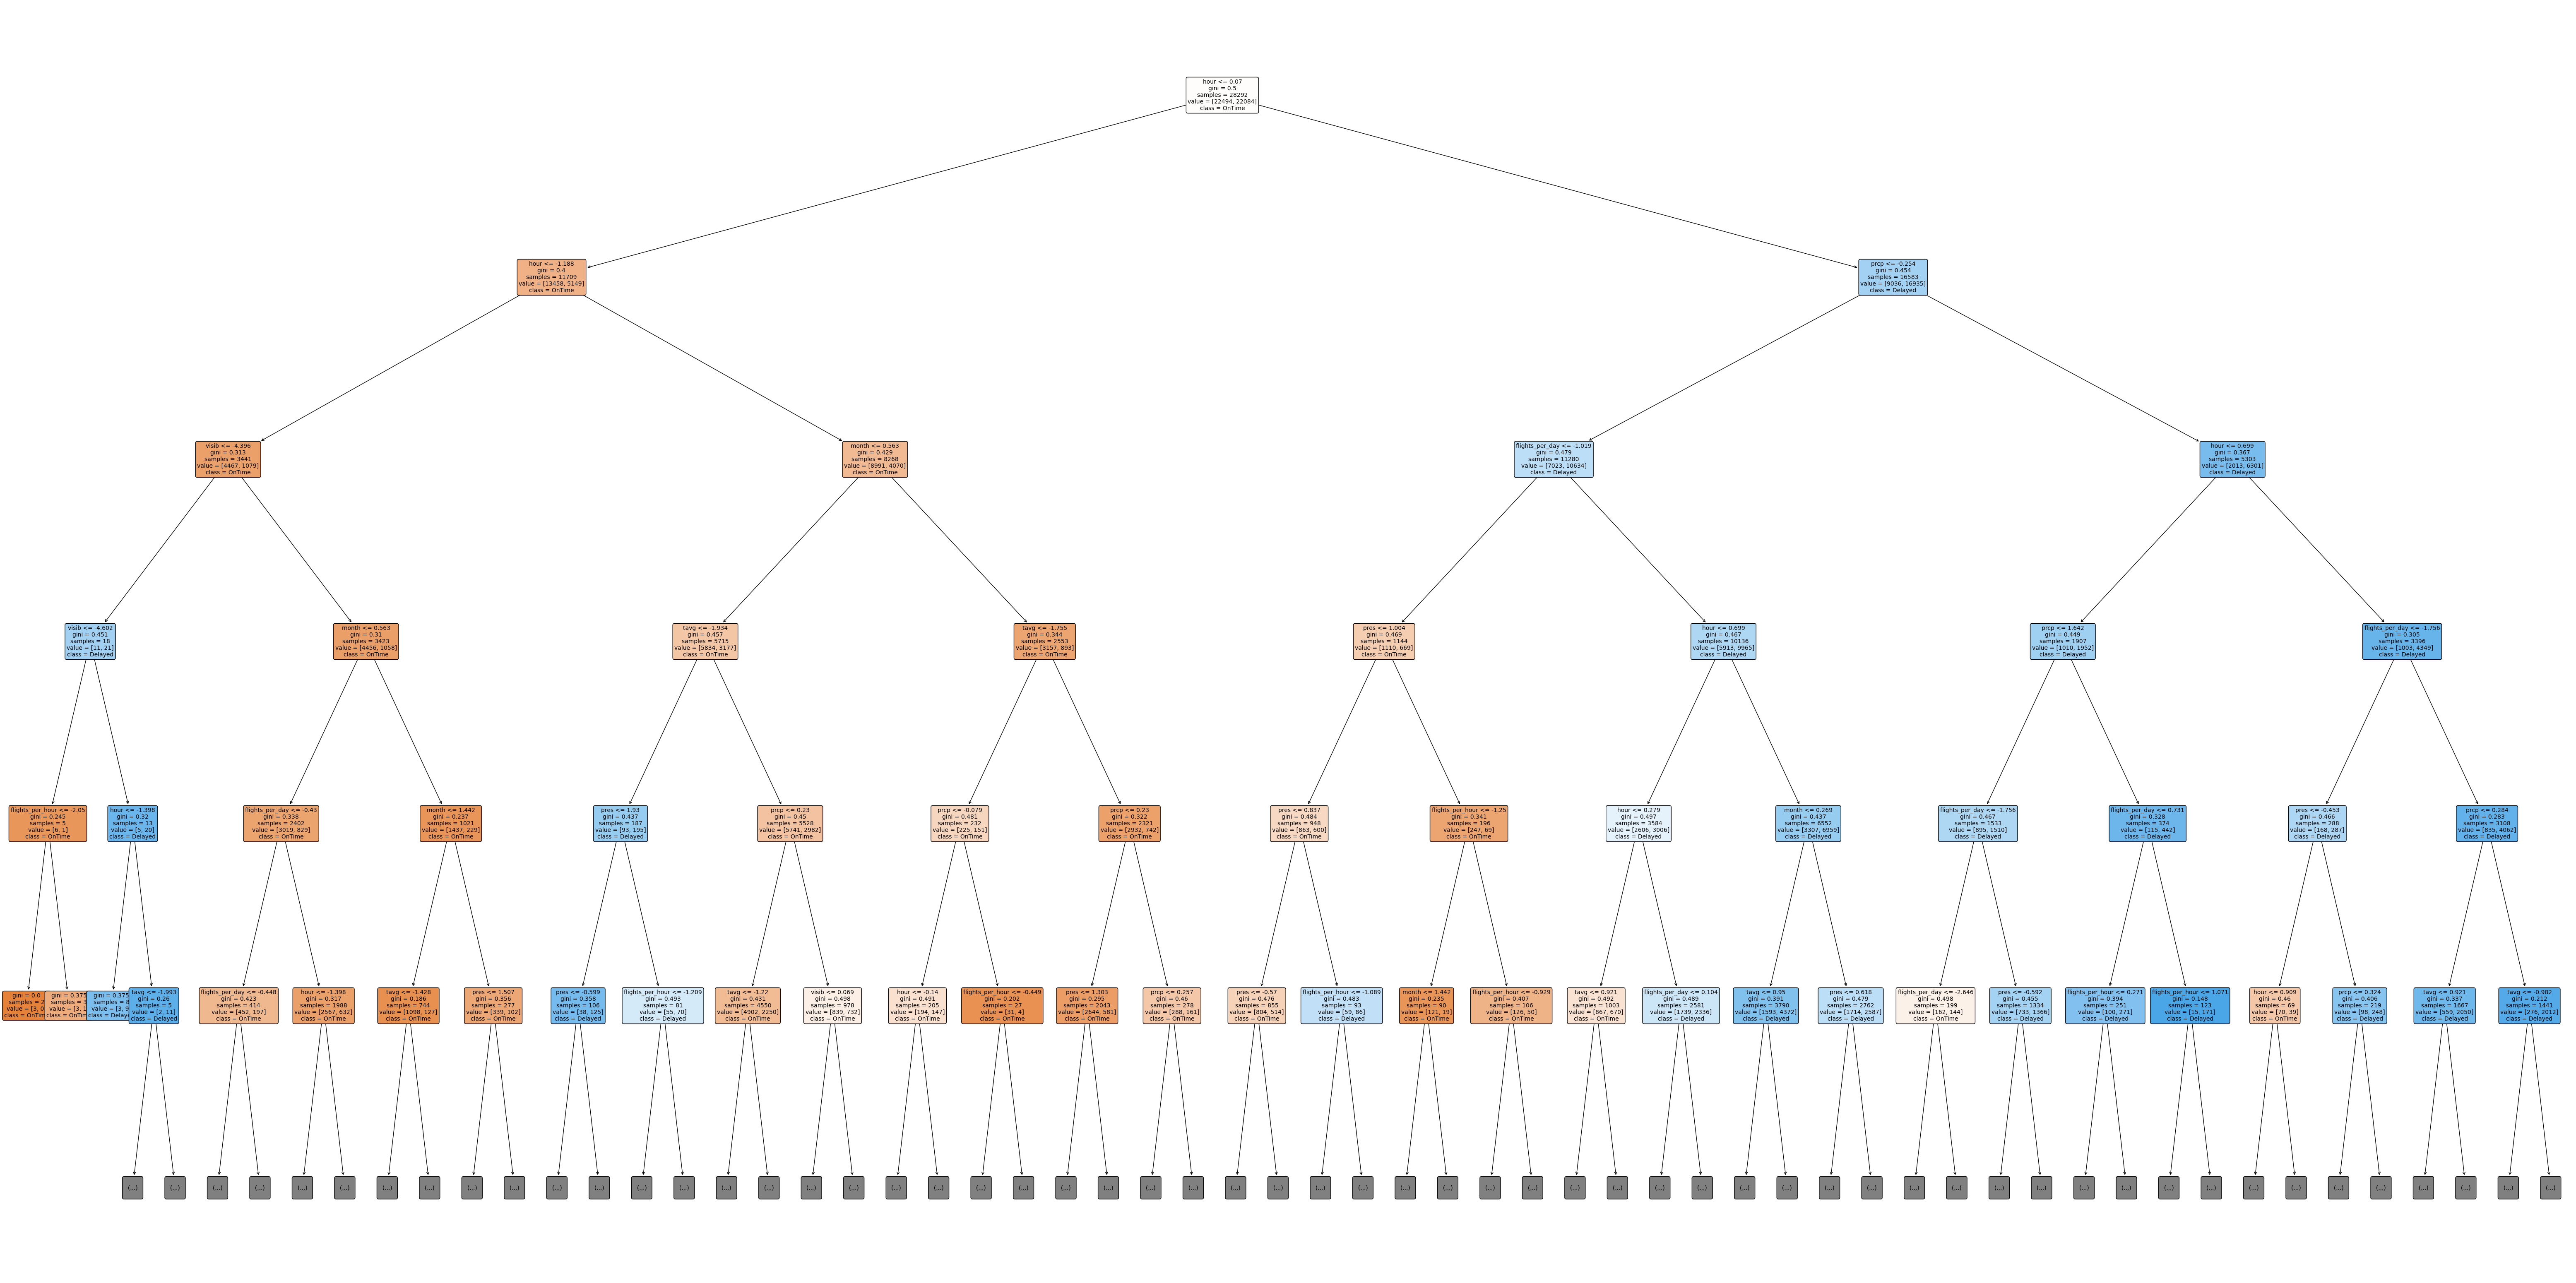

In [29]:
%matplotlib inline

# set the figure size
fig = plt.figure(figsize=(80, 40))

# plot the decision tree
plot_tree(model.estimators_[0], # Pull out one tree from the forest
          max_depth = 5,
          feature_names = delay_pred_names,
          class_names = delay_resp_names, 
          filled=True,
          fontsize=10,
          rounded=True)

plt.savefig(plot_tree_filename)
plt.show()

In [30]:
importances = list(model.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature,
                       importance in zip(delay_pred_names, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: hour                                     Importance: 0.59
Variable: flights_per_day                          Importance: 0.11
Variable: prcp                                     Importance: 0.08
Variable: pres                                     Importance: 0.07
Variable: tavg                                     Importance: 0.06
Variable: month                                    Importance: 0.04
Variable: flights_per_hour                         Importance: 0.04
Variable: visib                                    Importance: 0.01


## Confusion matrix and classification report

In [31]:
# create balanced test set
bal_delay_pred_test, bal_delay_resp_test = delay_pred_test, delay_resp_test.copy()
print(Counter(bal_delay_resp_test))

under = RandomUnderSampler(sampling_strategy=1)
bal_delay_pred_test, bal_delay_resp_test = under.fit_resample(bal_delay_pred_test, bal_delay_resp_test)
print(Counter(bal_delay_resp_test))

Counter({0: 17003, 1: 5611})
Counter({0: 5611, 1: 5611})


In [32]:
y_pred = model.predict(bal_delay_pred_test)
cm = confusion_matrix(bal_delay_resp_test, y_pred)
cm

array([[4023, 1588],
       [1643, 3968]], dtype=int64)

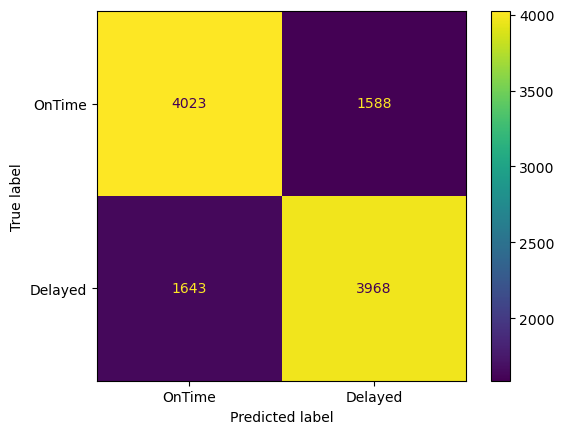

In [33]:
# plot confusion matrix
cm = confusion_matrix(bal_delay_resp_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=delay_resp_names)
disp.plot()
plt.show()

In [34]:
# get classification report
print(classification_report(bal_delay_resp_test, y_pred, target_names=delay_resp_names))

              precision    recall  f1-score   support

      OnTime       0.71      0.72      0.71      5611
     Delayed       0.71      0.71      0.71      5611

    accuracy                           0.71     11222
   macro avg       0.71      0.71      0.71     11222
weighted avg       0.71      0.71      0.71     11222

